In [ ]:
!pip install nnfs
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

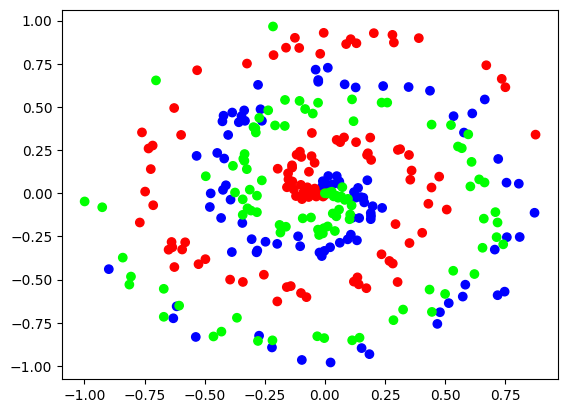

In [ ]:
import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:,0],X[:,1],c=y, cmap='brg')
plt.show()

In [ ]:
class Layer_Dense:
  def __init__(self, n_inputs, n_neurons):
    self.weights = 0.01*np.random.randn(n_inputs, n_neurons)
    self.biases = np.zeros((1, n_neurons))

  def forward(self, inputs):
    self.inputs = inputs # to make it available for backpropogation
    self.output = np.dot(inputs, self.weights) + self.biases

  def backward(self, dvalues):
    self.dweights = np.dot(self.inputs.T, dvalues)
    self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
    self.dinputs = np.dot(dvalues, self.weights.T)

In [ ]:
class Activation_ReLU:
  def forward(self, inputs):
    self.inputs = inputs
    self.output = np.maximum(0, inputs)

  def backward(self, dvalues):
    self.dinputs = dvalues.copy()
    self.dinputs[self.inputs<=0] = 0

In [ ]:
class Activation_Softmax:

  def forward(self, inputs):
    exp_vals = np.exp(inputs-np.max(inputs, axis=1, keepdims=True))
    self.output = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

In [ ]:
class Loss:
  # you calculate the mean of the losses in this class
  def calculate(self, output, y):
    sample_losses = self.forward(output, y)
    data_loss = np.mean(sample_losses)
    return data_loss

In [ ]:
class Loss_CategoricalCrossentropy(Loss):

  def forward(self, y_pred, y_true):
    samples = len(y_pred)
    y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
    if len(y_true.shape)==1:
      correct_confidences = y_pred_clipped[range(samples), y_true]
    # one hot encoded
    elif len(y_true.shape)==2:
      correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

    negative_log_likelihoods = -np.log(correct_confidences)
    return negative_log_likelihoods


  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    labels = len(dvalues[0])

    if len(y_true.shape)==1:
      y_true = np.eye(labels)[y_true]

    self.dinputs = -y_true/ dvalues
    self.dinputs = self.dinputs/samples

In [ ]:
class Activation_Softmax_Loss_CategoricalCrossentropy:
  def __init__(self):
    self.activation = Activation_Softmax()
    self.loss = Loss_CategoricalCrossentropy()

  def forward(self, inputs, y_true):
    self.activation.forward(inputs)
    self.output = self.activation.output
    return self.loss.calculate(self.output, y_true)

  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    if len(y_true.shape)==2:
      y_true = np.argmax(y_true, axis = 1)
    self.dinputs = dvalues.copy()
    self.dinputs[range(samples), y_true]-=1
    self.dinputs = self.dinputs/samples

In [ ]:
#adam optimiser
import numpy as np
class Optimizer_Adam:
  def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.beta_1 = beta_1
    self.beta_2 = beta_2

  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

  def update_params(self, layer):
    if not hasattr(layer, 'weight_cache'):
      layer.weight_momentums = np.zeros_like(layer.weights)
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_momentums = np.zeros_like(layer.biases)
      layer.bias_cache = np.zeros_like(layer.biases)

    layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
    layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

    weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
    bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

    layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
    layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

    weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
    bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

    layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
    layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

  def post_update_params(self):
        self.iterations += 1

In [ ]:
import numpy as np


X, y = spiral_data(samples=100, classes=3)

# Creating Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

for epoch in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')


    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.320, loss: 1.099, lr: 0.02
epoch: 100, acc: 0.627, loss: 0.862, lr: 0.01998021958261321
epoch: 200, acc: 0.683, loss: 0.686, lr: 0.019960279044701046
epoch: 300, acc: 0.747, loss: 0.616, lr: 0.019940378268975763
epoch: 400, acc: 0.743, loss: 0.577, lr: 0.01992051713662487
epoch: 500, acc: 0.780, loss: 0.556, lr: 0.01990069552930875
epoch: 600, acc: 0.780, loss: 0.539, lr: 0.019880913329158343
epoch: 700, acc: 0.763, loss: 0.515, lr: 0.019861170418772778
epoch: 800, acc: 0.743, loss: 0.506, lr: 0.019841466681217078
epoch: 900, acc: 0.757, loss: 0.488, lr: 0.01982180200001982
epoch: 1000, acc: 0.793, loss: 0.473, lr: 0.019802176259170884
epoch: 1100, acc: 0.807, loss: 0.452, lr: 0.01978258934311912
epoch: 1200, acc: 0.833, loss: 0.428, lr: 0.01976304113677013
epoch: 1300, acc: 0.833, loss: 0.406, lr: 0.019743531525483964
epoch: 1400, acc: 0.850, loss: 0.381, lr: 0.01972406039507293
epoch: 1500, acc: 0.850, loss: 0.364, lr: 0.019704627631799327
epoch: 1600, acc: 0.867, lo